In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tables as ta
import numpy.ma as matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import time
from sklearn import decomposition as de
from scipy.linalg import pinv
import importlib as il
import scipy.optimize as opt
import sklearn.svm as svm
import scipy.io as sio
import copy

In [2]:
import src.deh as deh

In [3]:
il.reload(deh)

<module 'src.deh' from '/home/josephg/repos/hUH/src/deh.py'>

In [4]:
jasp = sio.loadmat("../../Documents/labelled_scenes/jasperRidge2_R198.mat")

In [5]:
#with version 0 and tightened constraints, with one loop, switched to spatial and increased min size
# looks like the lower threshold does help to split the water
deh2 = deh.DEH(no_negative_residuals=True)
deh2.splitting_size=1000
deh2.max_depth=2
deh2.max_iter=0
deh2.plot_size = (100,100)
deh2.plot_aspect = 1

In [6]:
ji = (jasp['Y'].astype(np.float32).T)

In [ ]:
# this will give a lot of output because I didn't implement verbose=False yet
samppts = np.random.choice(10000,1000)
o_rec = [0]
deh2.grow_network_open(ji, beta=0.5, tol=1e-5, obj_record=o_rec, sampling_points=samppts)

4


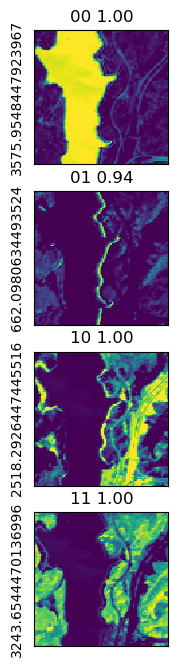

In [72]:
deh2.display_level(2)

In [76]:
o_rec.pop(0)

0

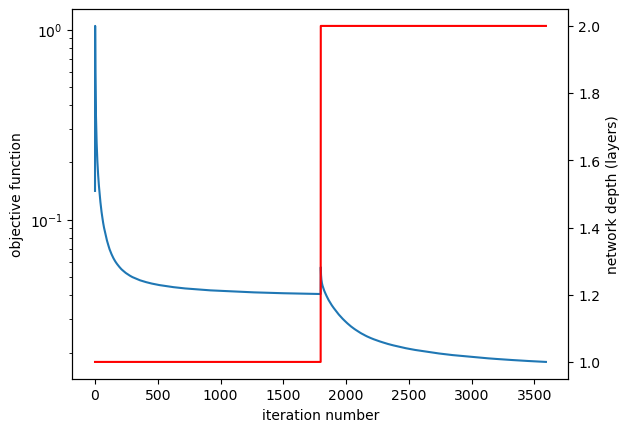

In [77]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
ax.semilogy(np.array(o_rec)[:,0])
ax.set_xlabel("iteration number")
ax.set_ylabel("objective function")
ax1.set_ylabel("network depth (layers)")
ax1.plot(np.array(o_rec)[:,2], color='red')

In [139]:
#with version 0 and tightened constraints, with one loop, switched to spatial and increased min size
# looks like the lower threshold does help to split the water
il.reload(deh)
deh3 = deh.DEH(no_negative_residuals=True)
deh3.splitting_size=1000
deh3.max_depth=2
deh3.max_iter=0
deh3.plot_size = (100,100)
deh3.plot_aspect = 1

In [ ]:
# this will give a lot of output because I didn't implement verbose=False yet
samppts = np.random.choice(10000,1000)
o_recI = [0]
deh3.grow_network_closed(ji, beta=0.7, tol=1e-6, betab=0.5, tolb=1e-6,
                         obj_record=o_recI, sampling_points=samppts, scaling_factor=16)

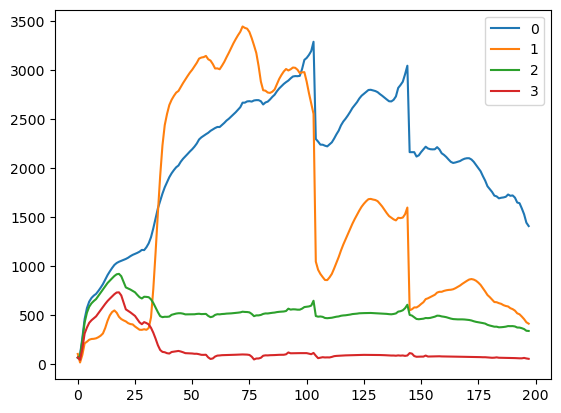

In [167]:
deh3.display_spectra(['00','01','10','11'])

In [159]:
o_recI.pop(0)

[0.34166834, 1.5, 1]

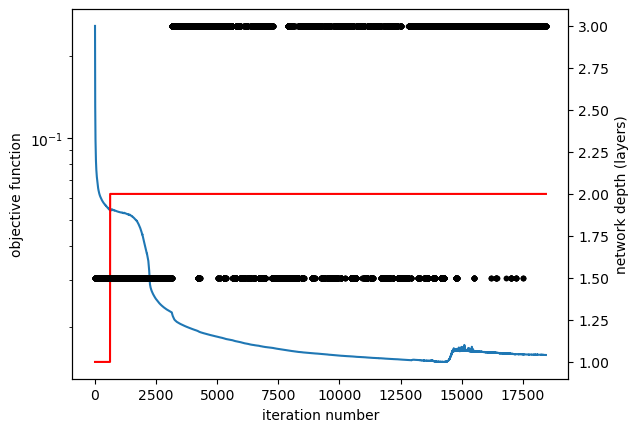

In [168]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
ax.semilogy(np.array(o_recI)[:,0])
ax.set_xlabel("iteration number")
ax.set_ylabel("objective function")
ax1.set_ylabel("network depth (layers)")
ax1.plot(np.array(o_recI)[:,2], color='red')
ax1.plot(np.array(o_recI)[:,1],'.', color='black')

4


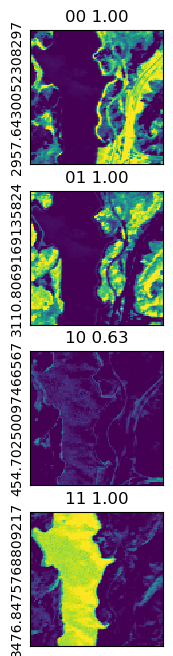

In [169]:
deh3.predict(ji)
deh3.display_level(2)

In [285]:
#Here you can experiment with randomly initializing the nodes
il.reload(deh)
deh4 = deh.DEH(no_negative_residuals=True)
deh4.splitting_size=1000
deh4.max_depth=2
deh4.max_iter=0
deh4.plot_size = (100,100)
deh4.plot_aspect = 1
deh4.random_init(ji, 16)

In [286]:
deh4.trim(2)

In [ ]:
# this will give a lot of output because I didn't implement verbose=False yet
deh4.switch_training(  ji, beta=0.1, tol=1e-6, n_update_points=200, sampling_points=samppts,
                      obj_record=o_recI, scaling_factor=16)

In [287]:
# now we'll try Erie

In [21]:
# I had trouble with the hypso package, so I downloaded it the old fashioned way
# you'll need to update a few absolute paths
from scipy import interpolate

In [22]:
path_to_F_bip = "/home/josephg/Documents/HYPSO/erie_2022-08-27_1605Z.bip"
finm = np.fromfile(path_to_F_bip, dtype='uint16')
# type in the relevant path the the calibration coeffs on your 
coeff_path = '/home/josephg/repos/cal-char-corr/FM-calibration/Coefficients/'
spectral_coeffs = np.genfromtxt(coeff_path + 'spectral_coeffs_FM_order2.csv', delimiter=',')
rad_coeffs = np.genfromtxt(coeff_path + 'rad_coeffs_FM_binx9_2022_08_06_Finnmark_recal_a.csv', delimiter=',')
spectral_band_matrix = np.genfromtxt(coeff_path+'spectral_calibration_matrix_HYPSO-1.csv', delimiter=',')

# this is just a bunch of calibration stuff that shouldn't change much
# you do need to check the exposure (exp) in the capture config.ini file

bin_x = 9 # binning factor
background_value = 8*bin_x
x_start = 428 # aoi_x
x_stop = 1508 # aoi_x + column_count 
y_start = 266 # aoi_y
y_stop = 950 # aoi_y + row_count
exp = 30/1000 # convert ms to s
exp_gloria = 30/1000


image_height = 684 # row_count
image_width = 120 # column_count/bin_factor
im_size = image_height*image_width

metad = [exp, image_height, image_width, x_start, x_stop, y_start, y_stop, bin_x]
metad_gloria = [exp_gloria, image_height, image_width, x_start, x_stop, y_start, y_stop, bin_x]

#cube = cube.reshape((-1,image_height,image_width))
#a few functions copied from Marie's calibration code, should update to just use as a library

def pixel_to_wavelength(x, spectral_coeffs):
    if len(spectral_coeffs) == 2:
        w = spectral_coeffs[1] + spectral_coeffs[0]*x
    elif len(spectral_coeffs) == 3:
        w = spectral_coeffs[2] + spectral_coeffs[1]*x + spectral_coeffs[0]*x*x
    elif len(spectral_coeffs) == 4:
        w = spectral_coeffs[3] + spectral_coeffs[2]*x + spectral_coeffs[1]*x*x + spectral_coeffs[0]*x*x*x
    elif len(spectral_coeffs) == 5:
        w = spectral_coeffs[4] + spectral_coeffs[3]*x + spectral_coeffs[2]*x*x + spectral_coeffs[1]*x*x*x + spectral_coeffs[0]*x*x*x*x
    else: 
        print('Please update spectrally_calibrate function to include this polynomial.')
        print('Returning 0.')
        w = 0
    return w

def apply_spectral_calibration(x_start, x_stop, image_width, spectral_coeffs):  
    x = np.linspace(x_start,x_stop,image_width) 
    w = pixel_to_wavelength(x, spectral_coeffs)
    return w

def apply_radiometric_calibration(frame, exp, background_value, radiometric_calibration_coefficients):
    ''' Assumes input is 12-bit values, and that the radiometric calibration
    coefficients are the same size as the input image.
    
    Note: radiometric calibration coefficients have original size (684,1080),
    matching the "normal" AOI of the HYPSO-1 data (with no binning).'''
    
    frame = frame - background_value
    frame_calibrated = frame * radiometric_calibration_coefficients / exp
    
    return frame_calibrated

def calibrate_cube(cube, metadata, spectral_coeffs, rad_coeffs, background_value):
    
    [exp, image_height, image_width, x_start, x_stop, y_start, y_stop, bin_x] = metadata
    
    ## Spectral calibration
    w = apply_spectral_calibration(x_start, x_stop, image_width, spectral_coeffs)
    # x = np.linspace(x_start,x_stop,image_width) 
    # w = util.pixel_to_wavelength(x, spectral_coeffs)
    
    ## Radiometric calibration
    num_frames = cube.shape[0]
    cube_calibrated = np.zeros([num_frames, image_height, image_width], dtype=np.float32)
    for i in range(num_frames):
        frame = cube[i,:,:]
        frame_calibrated = apply_radiometric_calibration(frame, exp, background_value, rad_coeffs)
        cube_calibrated[i,:,:] = frame_calibrated
    
    ## Smile and keystone correction
    # TODO
    
    return cube_calibrated, w, metadata

fm, wl, metadata = calibrate_cube(finm.reshape((-1,
                                                    image_height,
                                                    image_width))[:,:,::-1],
                                    metad, 
                                    spectral_coeffs, 
                                    rad_coeffs, 
                                    background_value)

sat = np.max(fm.reshape((-1,120)), axis=1)> 130 
sat = sat.reshape((-1,684)) 

def smile_correction_one_row(row, w, w_ref):
    ''' Use cubic spline interpolation to resample one row onto the correct
    wavelengths/bands from a reference wavelength/band array to correct for
    the smile effect.
    '''
    row_interpolated = interpolate.splrep(w, row)
    row_corrected = interpolate.splev(w_ref, row_interpolated)
    # Set values for wavelengths below 400 nm to zero
    for i in range(len(w_ref)):
        w = w_ref[i]
        if w < 400:
            row_corrected[i] = 0
        else:
            break
    return row_corrected


def smile_correction_one_frame(frame, spectral_band_matrix):
    ''' Run smile correction on each row in a frame, using the center row as 
    the reference wavelength/band for smile correction.
    '''
    image_height, image_width = frame.shape
    center_row_no = int(image_height/2)
    w_ref = spectral_band_matrix[center_row_no]
    frame_smile_corrected = np.zeros([image_height, image_width])
    for i in range(image_height): # For each row
        this_w = spectral_band_matrix[i]
        this_row = frame[i]
        # Correct row
        row_corrected = smile_correction_one_row(this_row, this_w, w_ref)
        frame_smile_corrected[i,:] = row_corrected
    return frame_smile_corrected


def smile_correction_cube(cube, spectral_band_matrix):
    ''' Run smile correction on each frame in a cube, using the center row in 
    the frame as the reference wavelength/band for smile correction.
    '''
    num_frames, image_height, image_width = cube.shape
    cube_smile_corrected = np.zeros([num_frames, image_height, image_width])
    for i in range(num_frames):
        this_frame = cube[i,:,:]
        frame_smile_corrected = smile_correction_one_frame(this_frame, spectral_band_matrix)
        cube_smile_corrected[i,:,:] = frame_smile_corrected
    return cube_smile_corrected

def crop_and_bin_matrix(matrix, x_start, x_stop, y_start, y_stop, bin_x=1, bin_y=1):
    ''' Crops matrix to AOI. Bins matrix so that the average value in the bin_x 
    number of pixels is stored.
    '''
    # Crop to selected AOI
    new_matrix = matrix[y_start:y_stop, x_start:x_stop]
    height, width = new_matrix.shape

    # If bin is set to 0 or negative we assume this means no binning, aka bin=1
    if bin_x < 1:
        bin_x = 1
    if bin_y < 1:
        bin_y = 1

    # Bin spectral direction
    if bin_x != 1:
        width_binned = int(width/bin_x)
        matrix_cropped_and_binned = np.zeros((height,width_binned))
        for i in range(width_binned):
            this_pixel_sum = 0
            for j in range(bin_x):
                this_pixel_value = new_matrix[:,i*bin_x+j]
                this_pixel_sum += this_pixel_value
            average_pixel_value = this_pixel_sum/bin_x
            matrix_cropped_and_binned[:,i] = average_pixel_value
        new_matrix = matrix_cropped_and_binned

    # Bin spatial direction
    if bin_y != 1:
        height_binned = int(height/bin_y)
        matrix_binned_spatial = np.zeros((height_binned,width_binned))
        for i in range(height_binned):
            this_pixel_sum = 0
            for j in range(bin_y):
                this_pixel_value = new_matrix[i*bin_y+j,:]
                this_pixel_sum += this_pixel_value
            average_pixel_value = this_pixel_sum/bin_y
            matrix_binned_spatial[i,:] = average_pixel_value/bin_y
        new_matrix = matrix_binned_spatial

    return new_matrix

bin_x = 9 # binning factor
background_value = 8*bin_x
x_start = 428 # aoi_x
x_stop = 1508 # aoi_x + column_count 
y_start = 266 # aoi_y
y_stop = 950 # aoi_y + row_count

smile_corrector = crop_and_bin_matrix(spectral_band_matrix, 
                                           x_start,
                                           x_stop, 
                                           y_start,
                                           y_stop, 
                                           bin_x)
cube_smile_corrected = smile_correction_cube(fm, smile_corrector)

In [24]:
csc = cube_smile_corrected[:,:,4:].reshape((-1,116))

In [25]:
# this is my dark pixel subtraction compensation
mins = np.array([2*csc[:,i].min() - np.sort(csc[:,i])[1] for i in range(116)])

In [178]:
#with version 0 and tightened constraints, with one loop, switched to spatial and increased min size
# looks like the lower threshold does help to split the water
il.reload(deh)
deh5 = deh.DEH(no_negative_residuals=True)
deh5.splitting_size=1000
deh5.max_depth=3
deh5.max_iter=0
deh5.plot_size = (956,684)
deh5.plot_aspect = 0.3

In [ ]:
# this will give a lot of output because I didn't implement verbose=False yet
samppts = np.random.choice(956*684,1000)
o_rec = [0]
deh5.grow_network_closed(csc-mins, beta=.5, betab=.5, tolb=1e-5, tol=1e-5, obj_record=o_rec,
                         scaling_factor=4, sampling_points=samppts)

4


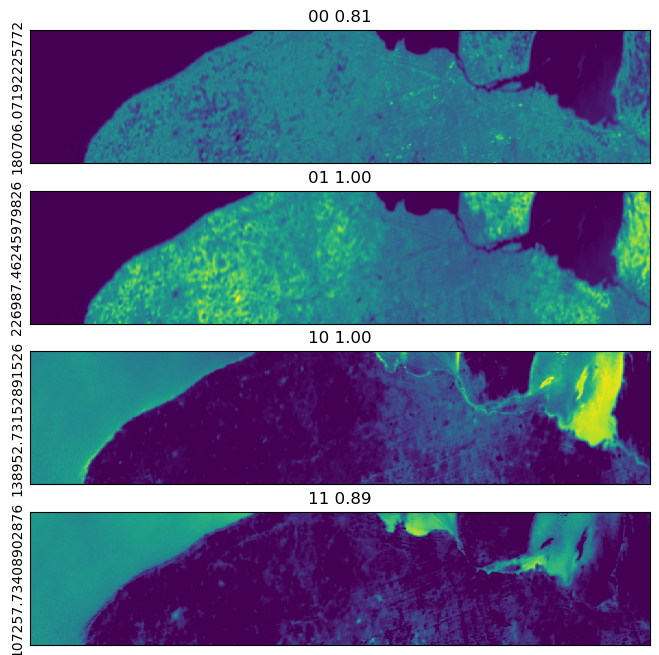

In [180]:
# Note that I plotted this before it had finished converging, as I ran out of time
deh5.predict(csc-mins)
deh5.display_level(2)

In [ ]:
# if you want to do extra training
deh5.switch_training(csc-mins, beta=0.9, tol=1e-6, obj_record=o_rec, sampling_points=samppts, scaling_factor=4)